# Implementing a GAN for MNIST Digit Synthesis

Alexi Canesse

**Objective**: Evaluate the candidate's understanding and application of deep learning principles, focusing on the design and implementation of Generative Adversarial Networks (GANs) using PyTorch for MNIST digit synthesis.

## **Step 1:** Basic GAN Implementation for MNIST Digit Synthesis


In [51]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.utils
from torch.jit import script
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# Load the tensorboard extension
%load_ext tensorboard

# Check for GPU availability and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [52]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        # Generator model architecture
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 196),  # Input layer: latent_dim to 196
            nn.ReLU(),
            nn.Linear(196, 784),  # Hidden layer: 196 to 784 (28 * 28)
            nn.Tanh()  # Output layer: Tanh for image generation in the range [-1, 1]
        )
        self.img_shape = img_shape  # Save the image shape for reshaping later

    def forward(self, z):
        # Forward pass through the generator
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)  # Reshape as an image
        return img

class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        # Discriminator model architecture
        self.model = nn.Sequential(
            nn.Linear(784, 196),  # Input layer: Flatten image to 784 (28 * 28)
            nn.ReLU(),
            nn.Linear(196, 1),  # Hidden layer: 196 to 1 (output probability)
            nn.Sigmoid()  # Output layer: Sigmoid for binary classification (real or fake)
        )
        self.img_shape = img_shape  # Save the image shape for reshaping later

    def forward(self, img):
        # Forward pass through the discriminator
        img_flat = img.view(img.size(0), -1)  # Flatten the image
        validity = self.model(img_flat)  # Output the probability of being real (1) or fake (0)
        return validity

Initialize the models and set hyperparameters:

In [53]:
batch_size = 1024
latent_dim = 49  # Dimension of the latent space (7 * 7)
img_shape = (1, 28, 28)  # Shape of the images from the dataset

# Instantiate the generator and discriminator, and move them to GPU if available
generator = script(Generator(latent_dim, img_shape).to(device))
discriminator = script(Discriminator(img_shape)).to(device)

# Define Binary Cross Entropy Loss for training
criterion = nn.BCELoss().to(device)

# Adam optimizers for generator and discriminator
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

Load MNIST dataset:

In [54]:
# Change the current working directory, necessary for my cluster
os.chdir("/scratch/acanesse")
!wget https://raw.githubusercontent.com/alexbogun/tensor_dataloader/main/tensor_dataloader.py

/bin/bash: /opt/conda3-23.3.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-11-23 16:03:36--  https://raw.githubusercontent.com/alexbogun/tensor_dataloader/main/tensor_dataloader.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4476 (4.4K) [text/plain]
Saving to: ‘tensor_dataloader.py.1’

tensor_dataloader.p 100%[===================>]   4.37K  --.-KB/s    in 0s      

2023-11-23 16:03:36 (63.9 MB/s) - ‘tensor_dataloader.py.1’ saved [4476/4476]



In [55]:
from tensor_dataloader import FastTensorDataset, FastTensorDataLoader
from torch.utils.data import TensorDataset

transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor values
])

def MNIST(train=True):
    ds = datasets.MNIST('./data', train=train)
    data, targets = ds.data.unsqueeze(1), ds.targets
    data = data / 255
    ds = TensorDataset(data, targets)
    return ds

def to_cuda_ftdl(dataset, batch_size=64, transform=None, shuffle=True):
    
    if type(dataset) is list:
        return [to_cuda_ftdl(ds, batch_size, transform, shuffle) for ds in dataset]

    if type(dataset) in [TensorDataset, FastTensorDataset]:
        X, Y = dataset.tensors
    else:
        X, Y = [],[]
        for x, y in dataset:
            X.append(x)
            Y.append(y)
        X = torch.stack(X)
        Y = torch.tensor(Y)

    X, Y = X.cuda(), Y.cuda()
    return FastTensorDataLoader(FastTensorDataset(X, Y, transform), batch_size, shuffle)

train_loader = to_cuda_ftdl(MNIST(True), batch_size=batch_size, transform=transform)
test_loader = to_cuda_ftdl(MNIST(False), batch_size=batch_size, transform=transform)

Visualize some examples from the dataset

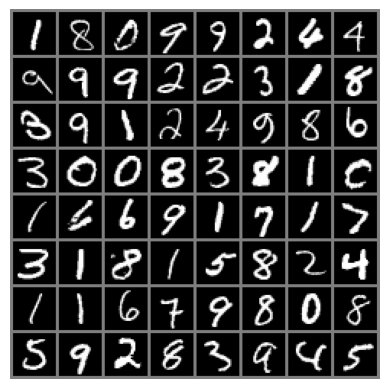

In [59]:
# Create an iterator for the test data loader
data_iter = iter(test_loader)

# Get one batch of data
images, labels = next(data_iter)
images, labels = images[:64], labels[:64]

# Display images
def imshow(img):
    # Unnormalize the image tensor values
    img = img / 2 + 0.5
    npimg = img.detach().cpu().numpy()
    # Transpose the image dimensions for correct display
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Show images using matplotlib
imshow(torchvision.utils.make_grid(images))
plt.show()


Load a previous checkpoint if it exists

In [79]:
# Define the filename for the checkpoint
checkpoint_file = 'gan_checkpoint.pth'

# Check if a checkpoint file exists
if os.path.exists(checkpoint_file):
    # Load checkpoint if it exists
    checkpoint = torch.load(checkpoint_file)
    epoch = checkpoint['epoch']
    
    # Load model and optimizer states from the checkpoint
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    
    # Load loss values from the checkpoint
    g_loss = checkpoint['g_loss']
    d_loss = checkpoint['d_loss']
    
    print(f"Checkpoint loaded. Resuming training.")
else:
    # If no checkpoint is found, start training from scratch
    print("No checkpoint found. Starting training from scratch.")

Checkpoint loaded. Resuming training.


Training Loop:

In [77]:
num_epochs = 500

# Initialize a SummaryWriter for TensorBoard logging
writer = SummaryWriter()

# Training loop
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        #imgs = imgs.to(device)
        
        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # Train Generator
        optimizer_G.zero_grad(set_to_none=True)
        z = torch.randn(imgs.size(0), latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad(set_to_none=True)
        real_loss = criterion(discriminator(imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    # Log losses to TensorBoard
    writer.add_scalar('Generator Loss', g_loss.item(), epoch)
    writer.add_scalar('Discriminator Loss', d_loss.item(), epoch)

    # Print progress
    print(f"Epoch [{epoch}/{num_epochs}] \t Generator Loss: {g_loss.item():.4f} \t Discriminator Loss: {d_loss.item():.4f}")

# Close the TensorBoard writer
writer.close()

Epoch [0/500] 	 Generator Loss: 0.9239 	 Discriminator Loss: 0.6290
Epoch [1/500] 	 Generator Loss: 1.0292 	 Discriminator Loss: 0.5594
Epoch [2/500] 	 Generator Loss: 0.8730 	 Discriminator Loss: 0.6758
Epoch [3/500] 	 Generator Loss: 1.0421 	 Discriminator Loss: 0.5677
Epoch [4/500] 	 Generator Loss: 0.8684 	 Discriminator Loss: 0.6949
Epoch [5/500] 	 Generator Loss: 0.9509 	 Discriminator Loss: 0.6604
Epoch [6/500] 	 Generator Loss: 0.9633 	 Discriminator Loss: 0.6942
Epoch [7/500] 	 Generator Loss: 0.8413 	 Discriminator Loss: 0.7106
Epoch [8/500] 	 Generator Loss: 0.9650 	 Discriminator Loss: 0.5764
Epoch [9/500] 	 Generator Loss: 0.8506 	 Discriminator Loss: 0.6588
Epoch [10/500] 	 Generator Loss: 0.8247 	 Discriminator Loss: 0.6715
Epoch [11/500] 	 Generator Loss: 0.8628 	 Discriminator Loss: 0.6339
Epoch [12/500] 	 Generator Loss: 0.8039 	 Discriminator Loss: 0.6749
Epoch [13/500] 	 Generator Loss: 0.8553 	 Discriminator Loss: 0.6465
Epoch [14/500] 	 Generator Loss: 0.8096 	 Di

Visualize training data

In [60]:
%tensorboard --logdir=runs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/scratch/acanesse/pytorch_env/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/scratch/acanesse/pytorch_env/lib/python3.8/site-packages/tensorboard/main.py", line 43, in <module>
    from tensorboard import default
  File "/scratch/acanesse/pytorch_env/lib/python3.8/site-packages/tensorboard/default.py", line 36, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "/scratch/acanesse/pytorch_env/lib/python3.8/site-packages/tensorboard/plugins/audio/audio_plugin.py", line 22, in <module>
    from werkzeug import wrappers
  File "/scratch/acanesse/pytorch_env/lib/python3.8/site-packages/werkzeug/__init__.py", line 2, in <module>
    from .test import Client as Client
  File "/scratch/acanesse/pytorch_env/lib/python3.8/site-packages/werkzeug/test.py", line 19, in <module>
    from .datastructures import Authorizati

Save the checkpoint for futur use and/or further training

In [76]:
# Create a dictionary for the checkpoint
checkpoint = {
    'epoch': epoch,
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'g_loss': g_loss.item(),
    'd_loss': d_loss.item()
}

# Save the checkpoint to a file
torch.save(checkpoint, 'gan_checkpoint.pth')

Testing the model:

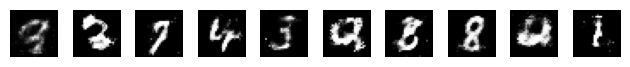

In [80]:
# Generate Images
num_samples = 10

# Generate random noise vectors
with torch.no_grad():
    z = torch.randn(num_samples, latent_dim).to(device)
    generated_images = generator(z).cpu().detach().numpy()

# Visualize generated images
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(generated_images[i][0], cmap='gray')  # Display the generated image
    plt.axis('off')

plt.tight_layout()
plt.savefig("gan.pdf")
plt.show()


## **Step 2:** Conditional GAN Implementation

Define a modified version of the model

In [81]:
# Define a Conditional Generator
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, img_shape, num_classes):
        super(ConditionalGenerator, self).__init__()
        self.num_classes = num_classes
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 196),  # Adjust input size for conditional information
            nn.ReLU(),
            nn.Linear(196, 784),
            nn.Tanh()
        )
        self.img_shape = img_shape

    def forward(self, z, labels):
        # One-hot encode the labels
        labels_onehot = F.one_hot(labels, num_classes=self.num_classes).float()
        
        # Concatenate one-hot encoded labels with the noise vector
        z = torch.cat((z, labels_onehot), dim=1)

        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Define a Conditional Discriminator
class ConditionalDiscriminator(nn.Module):
    def __init__(self, img_shape, num_classes):
        super(ConditionalDiscriminator, self).__init__()
        self.num_classes = num_classes
        self.model = nn.Sequential(
            nn.Linear(784 + num_classes, 196),  # Adjust input size for conditional information
            nn.ReLU(),
            nn.Linear(196, 1),
            nn.Sigmoid()
        )
        self.img_shape = img_shape

    def forward(self, img, labels):
        # One-hot encode the labels
        labels_onehot = F.one_hot(labels, num_classes=self.num_classes).float()
        # Reshape one-hot encoded labels to match the size of the image
        emb = labels_onehot.view(labels.size(0), -1)
        
        img_flat = img.view(img.size(0), -1)
        x = torch.cat((img_flat, emb), dim=1)
        validity = self.model(x)
        return validity


Initialize the models and set hyperparameters:

In [82]:
# Number of classes (one class for each digit)
num_classes = 10

# Instantiate conditional generator and discriminator, and move them to GPU if available
conditional_generator = script(ConditionalGenerator(latent_dim, img_shape, num_classes).to(device))
conditional_discriminator = script(ConditionalDiscriminator(img_shape, num_classes).to(device))

# Loss and optimizer for conditional GAN
criterion = nn.BCELoss()
conditional_optimizer_G = optim.Adam(conditional_generator.parameters(), lr=0.0002)
conditional_optimizer_D = optim.Adam(conditional_discriminator.parameters(), lr=0.0002)

Load a previous checkpoint if it exists

In [83]:
# Define the filename for the conditional GAN checkpoint
conditional_checkpoint_file = 'cgan_checkpoint.pth'

# Check if a conditional GAN checkpoint file exists
if os.path.exists(conditional_checkpoint_file):
    # Load conditional GAN checkpoint if it exists
    checkpoint = torch.load(conditional_checkpoint_file)
    epoch = checkpoint['epoch']
    
    # Load model and optimizer states from the checkpoint
    conditional_generator.load_state_dict(checkpoint['generator_state_dict'])
    conditional_discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    conditional_optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    conditional_optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    
    # Load loss values from the checkpoint
    conditional_g_loss = checkpoint['g_loss']
    conditional_d_loss = checkpoint['d_loss']
    
    print(f"Conditional GAN Checkpoint loaded. Resuming training.")
else:
    # If no checkpoint is found, start training conditional GAN from scratch
    print("No checkpoint found. Starting training from scratch.")


Conditional GAN Checkpoint loaded. Resuming training.


Training Loop:

In [84]:
# Number of epochs for training
num_epochs = 50

# Initialize a SummaryWriter for TensorBoard logging
writer = SummaryWriter()

# Conditional GAN training loop
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)

        # Train Generator
        conditional_optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim, device=device)
        gen_imgs = conditional_generator(z, labels)
        conditional_g_loss = criterion(conditional_discriminator(gen_imgs, labels), valid)
        conditional_g_loss.backward()
        conditional_optimizer_G.step()

        # Train Discriminator
        conditional_optimizer_D.zero_grad()
        real_loss = criterion(conditional_discriminator(imgs, labels), valid)
        fake_loss = criterion(conditional_discriminator(gen_imgs.detach(), labels), fake)
        conditional_d_loss = (real_loss + fake_loss) / 2
        conditional_d_loss.backward()
        conditional_optimizer_D.step()

    # Log losses to TensorBoard
    writer.add_scalar('Generator Loss', conditional_g_loss.item(), epoch)
    writer.add_scalar('Discriminator Loss', conditional_d_loss.item(), epoch)

    # Print progress
    print(f"Epoch [{epoch}/{num_epochs}] \t Generator Loss: {conditional_g_loss.item():.4f} \t Discriminator Loss: {conditional_d_loss.item():.4f}")

# Close the TensorBoard writer
writer.close()

Epoch [0/50] 	 Generator Loss: 0.7835 	 Discriminator Loss: 0.6700
Epoch [1/50] 	 Generator Loss: 0.8302 	 Discriminator Loss: 0.6270
Epoch [2/50] 	 Generator Loss: 0.7250 	 Discriminator Loss: 0.6974
Epoch [3/50] 	 Generator Loss: 0.7465 	 Discriminator Loss: 0.6741
Epoch [4/50] 	 Generator Loss: 0.7358 	 Discriminator Loss: 0.7044
Epoch [5/50] 	 Generator Loss: 0.8079 	 Discriminator Loss: 0.6348
Epoch [6/50] 	 Generator Loss: 0.7838 	 Discriminator Loss: 0.6710
Epoch [7/50] 	 Generator Loss: 0.7907 	 Discriminator Loss: 0.6535
Epoch [8/50] 	 Generator Loss: 0.7905 	 Discriminator Loss: 0.6503
Epoch [9/50] 	 Generator Loss: 0.7945 	 Discriminator Loss: 0.6786
Epoch [10/50] 	 Generator Loss: 0.8304 	 Discriminator Loss: 0.6219
Epoch [11/50] 	 Generator Loss: 0.8073 	 Discriminator Loss: 0.6606
Epoch [12/50] 	 Generator Loss: 0.7192 	 Discriminator Loss: 0.7306
Epoch [13/50] 	 Generator Loss: 0.8124 	 Discriminator Loss: 0.6381
Epoch [14/50] 	 Generator Loss: 0.8086 	 Discriminator Los

In [32]:
%tensorboard --logdir=runs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/scratch/acanesse/pytorch_env/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/scratch/acanesse/pytorch_env/lib/python3.8/site-packages/tensorboard/main.py", line 43, in <module>
    from tensorboard import default
  File "/scratch/acanesse/pytorch_env/lib/python3.8/site-packages/tensorboard/default.py", line 36, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "/scratch/acanesse/pytorch_env/lib/python3.8/site-packages/tensorboard/plugins/audio/audio_plugin.py", line 22, in <module>
    from werkzeug import wrappers
  File "/scratch/acanesse/pytorch_env/lib/python3.8/site-packages/werkzeug/__init__.py", line 2, in <module>
    from .test import Client as Client
  File "/scratch/acanesse/pytorch_env/lib/python3.8/site-packages/werkzeug/test.py", line 19, in <module>
    from .datastructures import Authorizati

Save the checkpoint for futur use and/or further training

In [31]:
# Create a dictionary for the conditional GAN checkpoint
checkpoint = {
    'epoch': epoch,
    'generator_state_dict': conditional_generator.state_dict(),
    'discriminator_state_dict': conditional_discriminator.state_dict(),
    'optimizer_G_state_dict': conditional_optimizer_G.state_dict(),
    'optimizer_D_state_dict': conditional_optimizer_D.state_dict(),
    'g_loss': conditional_g_loss.item(),
    'd_loss': conditional_d_loss.item()
}

# Save the conditional GAN checkpoint to a file
torch.save(checkpoint, 'cgan_checkpoint.pth')

Testing the model:

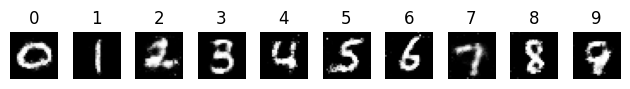

In [86]:
# Generate one image for each digit
num_digits = 10

with torch.no_grad():
    for digit in range(num_digits):
        # Generate random noise vector and label for the specified digit
        z = torch.randn(1, latent_dim).to(device)
        label = torch.tensor([digit], dtype=torch.long).to(device)
        
        # Generate image using the conditional generator
        generated_image = conditional_generator(z, label).cpu().detach().numpy()

        # Visualize generated image
        plt.subplot(1, num_digits, digit+1)
        plt.imshow(generated_image[0][0], cmap='gray')  # Display the generated image
        plt.title(f'{digit}')
        plt.axis('off')

plt.tight_layout()
plt.savefig("cgan.pdf")

plt.show()

## **Step 3:** Integrating an Encoder into the GAN

Define a modified version of the model

In [87]:
# Check https://arxiv.org/pdf/1611.06355.pdf to understand the model 
            
# Define an encoder for attribute information (classification model)
class AttributeEncoder(nn.Module):
    def __init__(self, num_classes):
        super(AttributeEncoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 196),  # Input size: 28 * 28 = 784, Output size: 196
            nn.ReLU(),
            nn.Linear(196, num_classes)  # Output size: Number of attribute classes
            # Note: CrossEntropyLoss combines both the softmax activation and the cross-entropy loss in a single, efficient computation.
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # Flatten the image
        return self.model(img_flat)

# Define an encoder for latent representation
class LatentEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(LatentEncoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 196),  # Input size: 28 * 28 = 784, Output size: 196
            nn.ReLU(),
            nn.Linear(196, latent_dim),  # Output size: Latent dimension
            nn.Sigmoid()  # Sigmoid activation to restrict values between 0 and 1
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # Flatten the image
        z = self.model(img_flat)
        return z


Initialize the models and set hyperparameters:

In [88]:
# Number of attribute classes
num_classes = 10

# Instantiate attribute encoder and latent encoder, and move them to GPU if available
attribute_encoder = script(AttributeEncoder(num_classes).to(device))
latent_encoder = script(LatentEncoder(latent_dim).to(device))

# Loss functions for attribute and latent encoders
criterion_attribute = nn.CrossEntropyLoss()  # Cross-entropy loss for attribute encoder
criterion_latent = nn.MSELoss()  # Mean squared error loss for latent encoder

# Optimizers for attribute and latent encoders
encoder_optimizer_y = optim.Adam(attribute_encoder.parameters(), lr=0.0002)
encoder_optimizer_z = optim.Adam(latent_encoder.parameters(), lr=0.0002)

Load a previous checkpoint if it exists

In [89]:
# Define the filename for the AttributeEncoder checkpoint
attribute_encoder_checkpoint_file = 'attribute_encoder_checkpoint.pth'

# Check if an AttributeEncoder checkpoint file exists
if os.path.exists(attribute_encoder_checkpoint_file):
    # Load AttributeEncoder checkpoint if it exists
    checkpoint = torch.load(attribute_encoder_checkpoint_file)
    epoch = checkpoint['epoch']
    
    # Load model and optimizer states from the checkpoint
    attribute_encoder.load_state_dict(checkpoint['model_state_dict'])
    encoder_optimizer_y.load_state_dict(checkpoint['encoder_optimizer_y_state_dict'])
    
    # Load loss values from the checkpoint
    encoder_y_loss = checkpoint['y_loss']
    
    print(f"Attribute Encoder Checkpoint loaded.")
else:
    # If no checkpoint is found, start training AttributeEncoder from scratch
    print("No checkpoint found. Starting training from scratch.")

Attribute Encoder Checkpoint loaded.


Training Loop: attribute encoder

In [90]:
num_epochs = 200
writer = SummaryWriter()

# Initialize early stopping parameters
best_loss = float('inf')
patience = 5  # Number of epochs with no improvement to wait before stopping
counter = 0

for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        # Train
        encoder_optimizer_y.zero_grad()
        gen_y = attribute_encoder(imgs)
        encoder_y_loss = criterion_attribute(gen_y, labels)
        encoder_y_loss.backward()
        encoder_optimizer_y.step()

    # Log to TensorBoard
    writer.add_scalar('Attribute Encoder Loss', encoder_y_loss.item(), epoch)


    # Validation on the test set
    test_loss = 0.0
    with torch.no_grad():
        for i, (test_imgs, test_labels) in enumerate(test_loader):
            test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
            gen_test_y = attribute_encoder(test_imgs)
            test_loss += criterion_attribute(gen_test_y, test_labels).item()

    test_loss /= len(test_loader.dataset)
    writer.add_scalar('Test Attribute Encoder Loss', test_loss, epoch)

    print(f"Epoch [{epoch}/{num_epochs}] \t Train Loss: {encoder_y_loss.item():.4f} \t Test Loss: {test_loss:.4f}")

    # Early stopping check
    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping at epoch {epoch} as no improvement in test loss.")
        break

# Close the TensorBoard writer
writer.close()

Epoch [0/200] 	 Train Loss: 0.0357 	 Test Loss: 0.0001
Epoch [1/200] 	 Train Loss: 0.0244 	 Test Loss: 0.0001
Epoch [2/200] 	 Train Loss: 0.0192 	 Test Loss: 0.0001
Epoch [3/200] 	 Train Loss: 0.0078 	 Test Loss: 0.0001
Epoch [4/200] 	 Train Loss: 0.0121 	 Test Loss: 0.0001
Epoch [5/200] 	 Train Loss: 0.0111 	 Test Loss: 0.0001
Epoch [6/200] 	 Train Loss: 0.0064 	 Test Loss: 0.0001
Epoch [7/200] 	 Train Loss: 0.0367 	 Test Loss: 0.0001
Epoch [8/200] 	 Train Loss: 0.0078 	 Test Loss: 0.0001
Epoch [9/200] 	 Train Loss: 0.0068 	 Test Loss: 0.0001
Early stopping at epoch 9 as no improvement in test loss.


Test the attribute encoder 

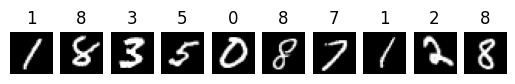

In [92]:
# Generate one image for each digit
data_iter = iter(test_loader)
images, _ = next(data_iter) # get one batch of data
gen_labels = [np.argmax(label) for label in attribute_encoder(images.to(device)).cpu().detach().numpy()]
num_exemples = min(len(images), 10)
for i, image in enumerate(images[:num_exemples]):
    plt.subplot(1, num_exemples, i + 1)
    plt.imshow(image.detach().cpu().numpy()[0], cmap='gray')
    plt.title(f'{gen_labels[i]}')
    plt.axis('off')

plt.show()

Save the checkpoint for futur use and/or further training

In [93]:
attribute_encoder_checkpoint_file = 'attribute_encoder_checkpoint.pth'

# Save checkpoint for the AttributeEncoder
attribute_encoder_checkpoint = {
    'epoch': epoch,
    'model_state_dict': attribute_encoder.state_dict(),
    'encoder_optimizer_y_state_dict': encoder_optimizer_y.state_dict(),
    'y_loss': encoder_y_loss,
}

torch.save(attribute_encoder_checkpoint, attribute_encoder_checkpoint_file)
print(f"Attribute Encoder Checkpoint saved.")

Attribute Encoder Checkpoint saved.


Load a previous checkpoint if it exists

In [94]:
# Define the filename for the LatentEncoder checkpoint
latent_encoder_checkpoint_file = 'latent_encoder_checkpoint.pth'

# Check if an LatentEncoder checkpoint file exists
if os.path.exists(latent_encoder_checkpoint_file):
    # Load LatentEncoder checkpoint if it exists
    checkpoint = torch.load(latent_encoder_checkpoint_file)
    epoch = checkpoint['epoch']
    
    # Load model and optimizer states from the checkpoint
    latent_encoder.load_state_dict(checkpoint['model_state_dict'])
    encoder_optimizer_z.load_state_dict(checkpoint['encoder_optimizer_z_state_dict'])
    
    # Load loss values from the checkpoint
    encoder_z_loss = checkpoint['z_loss']
    
    print(f"Latent Encoder Checkpoint loaded.")
else:
    # If no checkpoint is found, start training AttributeEncoder from scratch
    print("No checkpoint found. Starting training from scratch.")

Latent Encoder Checkpoint loaded.


Training Loop: latent encoder

In [95]:
# Number of epochs for training the latent encoder
num_epochs = 100

# Initialize a SummaryWriter for TensorBoard logging
writer = SummaryWriter()

# Initialize early stopping parameters
best_loss = float('inf')
patience = 10  # Number of epochs with no improvement to wait before stopping
counter = 0

# Latent encoder training loop
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        # Train latent encoder
        encoder_optimizer_z.zero_grad()
        gen_z = latent_encoder(imgs)
        encoder_z_loss = criterion_latent(conditional_generator(gen_z, labels), imgs)
        encoder_z_loss.backward()
        encoder_optimizer_z.step()

    # Log latent encoder loss to TensorBoard
    writer.add_scalar('Latent Encoder Loss', encoder_z_loss.item(), epoch)

    # Validation on the test set
    test_loss = 0.0
    with torch.no_grad():
        for i, (test_imgs, test_labels) in enumerate(test_loader):
            test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
            gen_test_z = latent_encoder(test_imgs)
            test_loss += criterion_latent(conditional_generator(gen_test_z, test_labels), test_imgs).item()

    test_loss /= len(test_loader.dataset)
    writer.add_scalar('Test Latent Encoder Loss', test_loss, epoch)

    # Print progress
    print(f"Epoch [{epoch}/{num_epochs}] \t Train Loss: {encoder_z_loss.item():.4f} \t Test Loss: {test_loss:.4f}")

    # Early stopping check
    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping at epoch {epoch} as no improvement in test loss.")
        break

# Close the TensorBoard writer
writer.close()

Epoch [0/100] 	 Train Loss: 0.1182 	 Test Loss: 0.0001
Epoch [1/100] 	 Train Loss: 0.1210 	 Test Loss: 0.0001
Epoch [2/100] 	 Train Loss: 0.1215 	 Test Loss: 0.0001
Epoch [3/100] 	 Train Loss: 0.1223 	 Test Loss: 0.0001
Epoch [4/100] 	 Train Loss: 0.1249 	 Test Loss: 0.0001
Epoch [5/100] 	 Train Loss: 0.1193 	 Test Loss: 0.0001
Epoch [6/100] 	 Train Loss: 0.1211 	 Test Loss: 0.0001
Epoch [7/100] 	 Train Loss: 0.1188 	 Test Loss: 0.0001
Epoch [8/100] 	 Train Loss: 0.1171 	 Test Loss: 0.0001
Epoch [9/100] 	 Train Loss: 0.1201 	 Test Loss: 0.0001
Epoch [10/100] 	 Train Loss: 0.1210 	 Test Loss: 0.0001
Epoch [11/100] 	 Train Loss: 0.1223 	 Test Loss: 0.0001
Epoch [12/100] 	 Train Loss: 0.1173 	 Test Loss: 0.0001
Epoch [13/100] 	 Train Loss: 0.1136 	 Test Loss: 0.0001
Epoch [14/100] 	 Train Loss: 0.1181 	 Test Loss: 0.0001
Epoch [15/100] 	 Train Loss: 0.1174 	 Test Loss: 0.0001
Epoch [16/100] 	 Train Loss: 0.1171 	 Test Loss: 0.0001
Epoch [17/100] 	 Train Loss: 0.1196 	 Test Loss: 0.0001
Ep

In [96]:
latent_encoder_checkpoint_file = 'latent_encoder_checkpoint.pth'

# Save checkpoint for the LatentEncoder
latent_encoder_checkpoint = {
    'epoch': epoch,
    'model_state_dict': latent_encoder.state_dict(),
    'encoder_optimizer_z_state_dict': encoder_optimizer_z.state_dict(),
    'z_loss': encoder_z_loss,
}

torch.save(latent_encoder_checkpoint, latent_encoder_checkpoint_file)
print(f"Latent Encoder Checkpoint saved.")

Latent Encoder Checkpoint saved.


Testing the latent encoder

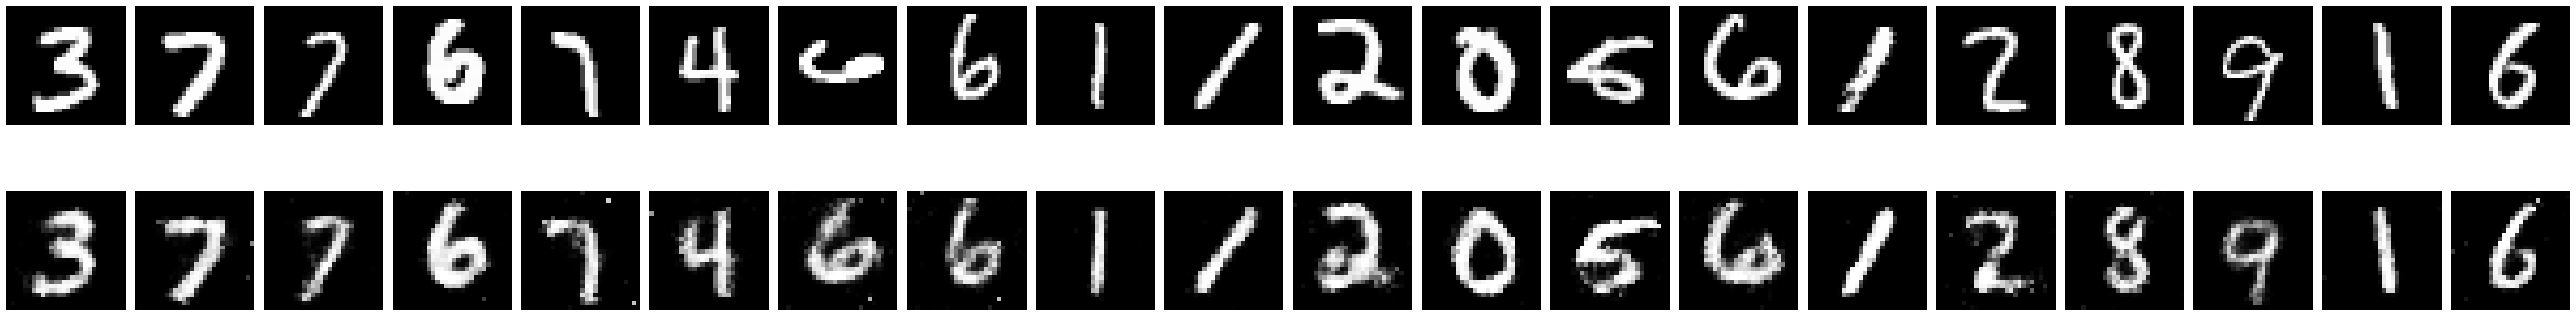

In [97]:
# Number of examples to visualize
num_examples = 20

with torch.no_grad():
    # Get one batch of data
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    imgs, labels = images.to(device), labels.to(device)

    # Encode images using the latent encoder
    gen_z = latent_encoder(imgs)

    # Generate reconstructions using the conditional generator
    gen_imgs = conditional_generator(gen_z, labels)

    # Convert PyTorch tensors to NumPy arrays
    imgs = imgs.cpu().numpy()[:num_examples]
    gen_imgs = gen_imgs.cpu().numpy()[:num_examples]

    # Display original and reconstructed images
    plt.figure(figsize=(2*num_examples, 7))
    for j in range(num_examples):
        # Original image
        plt.subplot(2, num_examples, j + 1)
        plt.imshow(np.transpose(imgs[j], (1, 2, 0)), cmap='gray')
        plt.axis('off')

        # Reconstructed image
        plt.subplot(2, num_examples, 1 + num_examples + j)
        plt.imshow(np.transpose(gen_imgs[j], (1, 2, 0)), cmap='gray')
        plt.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.savefig("reconstructions.pdf")
    plt.show()


Testing the model:

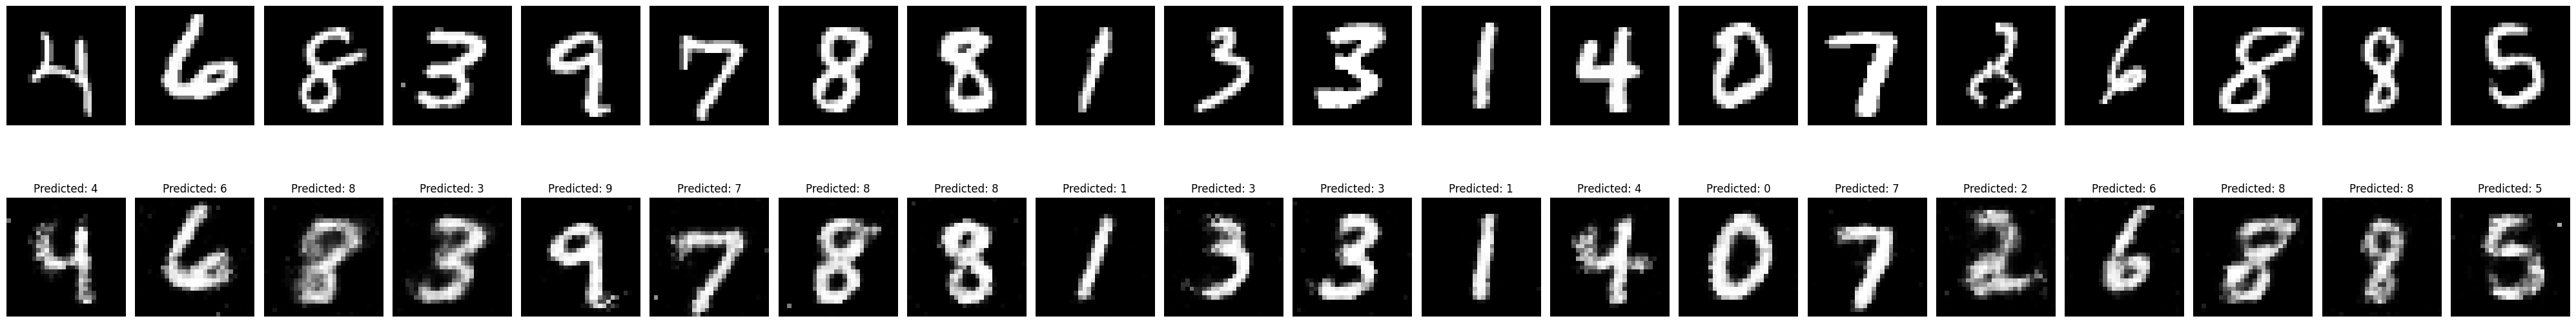

In [98]:
# Number of examples to visualize
num_examples = 20

with torch.no_grad():
    # Get one batch of data
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    imgs, labels = images.to(device), labels.to(device)

    # Encode images using the latent encoder
    gen_z = latent_encoder(imgs)

    # Generate labels using the attribute encoder
    gen_labels = torch.tensor([np.argmax(label) for label in attribute_encoder(imgs).detach().cpu().numpy()]).to(device)

    # Generate reconstructions using the conditional generator with predicted labels
    gen_imgs = conditional_generator(gen_z, gen_labels)

    # Convert PyTorch tensors to NumPy arrays
    imgs = imgs.cpu().numpy()[:num_examples]
    gen_imgs = gen_imgs.cpu().numpy()[:num_examples]

    # Display original and reconstructed images
    plt.figure(figsize=(2*num_examples, 7))
    for j in range(num_examples):
        # Original image
        plt.subplot(2, num_examples, j + 1)
        plt.imshow(np.transpose(imgs[j], (1, 2, 0)), cmap='gray')
        plt.axis('off')

        # Reconstructed image with predicted label
        plt.subplot(2, num_examples, 1 + num_examples + j)
        plt.imshow(np.transpose(gen_imgs[j], (1, 2, 0)), cmap='gray')
        plt.title(f'Predicted: {gen_labels[j]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Finally test the encoder with various attributes!

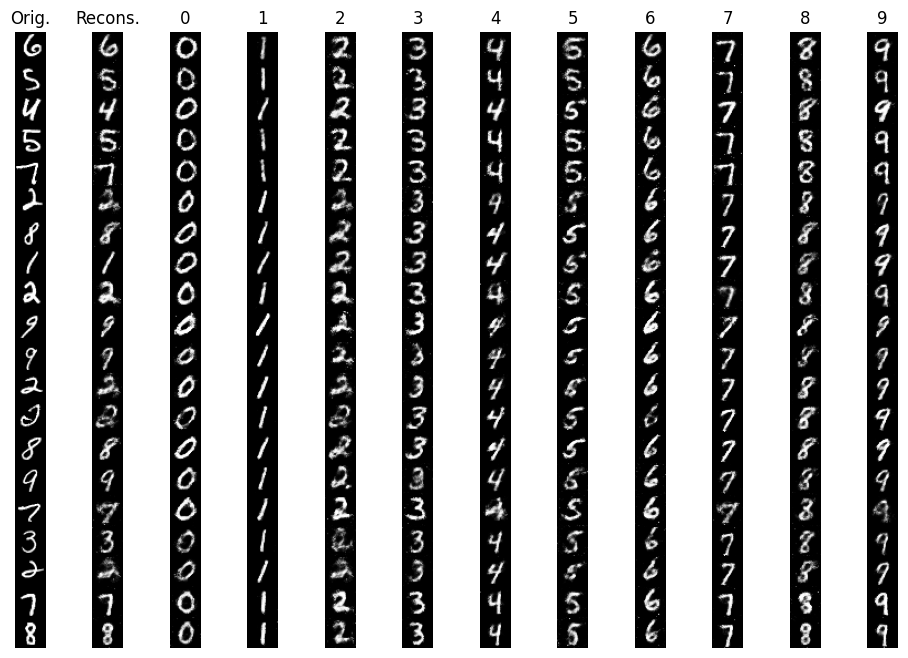

In [99]:
# Number of examples to visualize
num_examples = 20

with torch.no_grad():
    # Get one batch of data
    data_iter = iter(train_loader)
    images, labels = next(data_iter)

    imgs, labels = images.to(device), labels.to(device)

    # Encode images using the latent encoder
    gen_z = latent_encoder(imgs)

    # Generate labels using the attribute encoder
    gen_labels = torch.tensor([np.argmax(label) for label in attribute_encoder(imgs).detach().cpu().numpy()]).to(device)

    # Generate reconstructions using the conditional generator with predicted labels
    gen_imgs = conditional_generator(gen_z, gen_labels)
    
    # Generate reconstructions for each digit
    gen_imgs_digits = []
    for digit in range(10):
        gen_imgs_digits.append(conditional_generator(gen_z, torch.full((gen_z.shape[0],), digit, dtype=torch.long).to(device)).detach().cpu().numpy())

    # Convert PyTorch tensors to NumPy arrays
    imgs = imgs.cpu().numpy()[:num_examples]
    gen_imgs = gen_imgs.cpu().numpy()[:num_examples]

    # Display original, reconstructed, and digit-specific reconstructed images
    plt.figure(figsize=(12, 8))
    for j in range(num_examples):
        # Original image
        plt.subplot(num_examples, 12, 12*j + 1)
        plt.imshow(np.transpose(imgs[j], (1, 2, 0)), cmap='gray')
        plt.axis('off')
        if j == 0:
            plt.title('Orig.')

        # Reconstructed image with predicted label
        plt.subplot(num_examples, 12, 12*j + 2)
        plt.imshow(np.transpose(gen_imgs[j], (1, 2, 0)), cmap='gray')
        plt.axis('off')
        if j == 0:
            plt.title('Recons.')

        # Digit-specific reconstructed images
        for digit in range(10):
            plt.subplot(num_examples, 12, 12*j + 2 + digit + 1)
            plt.imshow(np.transpose(gen_imgs_digits[digit][j], (1, 2, 0)), cmap='gray')
            plt.axis('off')
            if j == 0:
                plt.title(f'{digit}')

    plt.subplots_adjust(wspace=0, hspace=0)  # Set spacing to zero
    plt.savefig("ecgan.pdf")
    plt.show()